# HAWC+ Data Analysis Techniques

In this jupyter cookbook, we will explore the [HAWC+](https://www.sofia.usra.edu/science/instruments/hawc) data cube and describe some of the basic analysis techniques involving imaging polarimetry data.

This cookbook follows the SOFIA press release of 30 Doradus observations: [SOFIA Reveals Never-Before-Seen Magnetic Field Details](https://www.sofia.usra.edu/multimedia/science-results-archive/sofia-reveals-never-seen-magnetic-field-details).

The Level 4 reduced data from this program has been released immediately to the public and is available on the [SOFIA Data Cycle System (DCS)](https://dcs.sofia.usra.edu/).  This notebook will guide the reader through downloading the 30 Doradus data with a walkthrough of basic analysis techniques with `python`.

# Downloading HAWC+ Data

- If you do not yet have a DCS account, register for one at [https://dcs.sofia.usra.edu/userSupport/registration.jsp](https://dcs.sofia.usra.edu/userSupport/registration.jsp)
- Log into DCS: [https://dcs.sofia.usra.edu](https://dcs.sofia.usra.edu)
- Go to [Search Science Archive](https://dcs.sofia.usra.edu/dataRetrieval/SearchScienceArchiveInfoBasic.jsp)
- Fill in:
  - Instrument: `HAWC_PLUS` from drop-down menu
  - Processing State: `LEVEL_4` from drop-down menu
  - Target: 30Dor (No need to resolve the name via Simbad or NED. If resolved use a large search radius, e.g. 600")
  - Click the `Submit` button
- After the results load, select the checkboxes next to each of the six rows of the table.
- Click `Get Selected Data in Current Page`
- Click `Request Data Bundle`
- After a few minutes, an email with a download link will be sent to the email address associated with your DCS account.
- For more information, consult the HAWC+ Data Handbook accessible at [https://www.sofia.usra.edu/science/proposing-and-observing/data-products/data-resources](https://www.sofia.usra.edu/science/proposing-and-observing/data-products/data-resources)

# SOFIA Data Organization
After downloading the SOFIA DCS bundle to your working directory you will want to unzip it, which will produce a directory structure like this:

Note that each file represents observations with a different filter.  However, two observations were made with the same filter (HAWC C, $89\,\mathrm{\mu m}$).  These files, `F0483_HA_POL_7600014_HAWCHWPC_PMP_022-065.fits` and `F0484_HA_POL_7600017_HAWCHWPC_PMP_065-114.fits`, were combined into one: `level4->p5813->F0484_HA_POL_7600018_HAWCHWPC_PMP_022-114.fits`.

You can choose to keep the `fits` files nested, or copy them into one directory.  [remove this] If you are feeling particularly courageous, the following `bash` command will flatten the current directory structure for you.

```console
foo@bar:~$ find . -mindepth 3 -type f -exec cp -i '{}' . ';'
```

For the purpose of this basic analysis, though, let us dump all the files into one `sofia_data` directory:

# Data Structure

Using [astropy](http://docs.astropy.org/en/stable/), we can explore the data HAWC+ `fits` data cubes:

In [8]:
# Widgets initialization
from ipywidgets import interact, IntSlider, ToggleButtons, interactive, Button
from IPython.display import display, Javascript
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
%matplotlib notebook
# ^jupyter magic for inline plots

fits_files = list(Path('sofia_data').glob('*.fits'))
values = [str(x) for x in fits_files]
labels = [x.split('HWP')[1] for x in values]

file_widget = ToggleButtons(
                options=list(zip(labels, values)),
                description='Select file:',
                disabled=False,
                tooltips=values
)

def open_file(filename):
    hdul = fits.open(filename)
    hdul.info()
    #display(Javascript('IPython.notebook.execute_cells_below()'))
    #display(Javascript('IPython.notebook.ensure_focused()'))
    #display(Javascript('IPython.notebook.get_selected_cell().element.focus()'))
    #display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index(),IPython.notebook.get_selected_index()+5)'))
    return hdul

def run_all(ev):
    display(Javascript('IPython.notebook.execute_cells_below()'))

button = Button(description='Re-run cells',
               disabled=False,
                button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
                tooltip='Re-run cells with selected file',
                icon='check'
)
button.on_click(run_all)

files = interactive(open_file, filename=file_widget)

In [9]:
from astropy.io import fits

# Select file below
display(files)
display(button)
hawc = files.result

# Or just read in filename
#  filename = 'sofia_data/F0485_HA_POL_76000110_HAWAHWPA_PMP_043-052.fits'
#  hawc = fits.open(filename)
#  hawc.info()

interactive(children=(ToggleButtons(description='Select file:', options=(('C_PMP_022-065.fits', 'sofia_data/F0…

Button(button_style='danger', description='Re-run cells', icon='check', style=ButtonStyle(), tooltip='Re-run c…

We can see above the data structure of the multi-extension `fits` files.  Each file contains 19 extensions which encapsulates all of the Stokes parameters in a single package.

## Stokes I
Stokes $I$---the zeroth extension in the `fits` file---represents the total intensity of the image, where $I^2 = Q^2 + U^2$.


Let us go ahead and plot this extension:

<IPython.core.display.Javascript object>


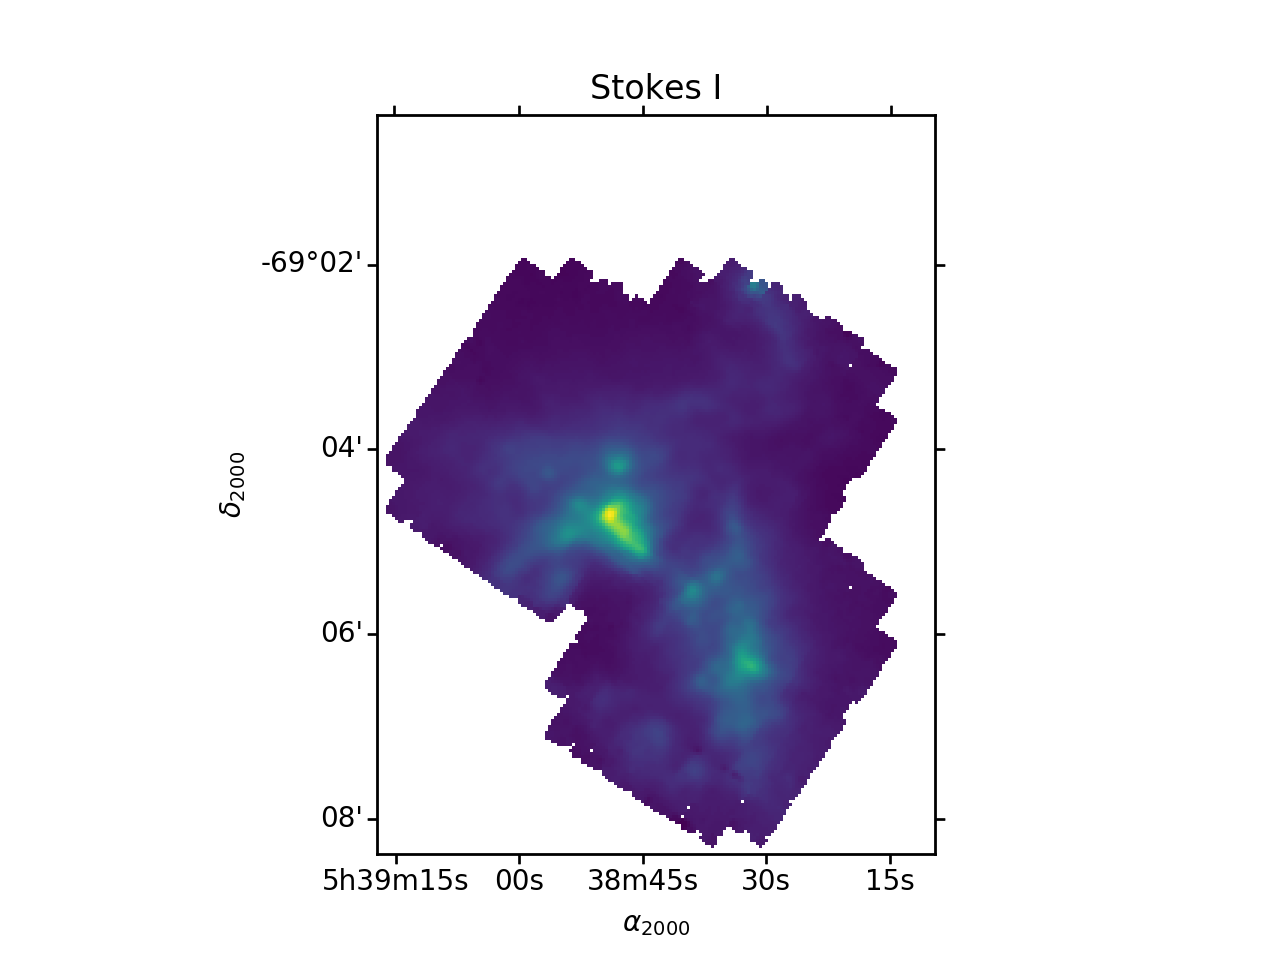

In [3]:
import matplotlib.pyplot as plt
#plt.rcParams['image.cmap'] = 'plasma'
from astropy.wcs import WCS
import numpy as np

stokes_i = hawc['STOKES I']          # or hawc_a[0]
stokes_i.wcs = WCS(stokes_i.header)    # read the WCS information from the header
                                       #  and store it in stokes_i.wcs

plt.figure()
axi = plt.subplot(projection=stokes_i.wcs)
axi.imshow(stokes_i.data, origin='lower')

# FORMATTING
axi.set_title('Stokes I')
axi.set_xlabel(r'$\alpha_{2000}$')
axi.set_ylabel(r'$\delta_{2000}$')
axi.coords[0].set_major_formatter('hh:mm:ss')

## Stokes Q and U
Similarly, we can plot the Stokes Q and Stokes U images:

<IPython.core.display.Javascript object>


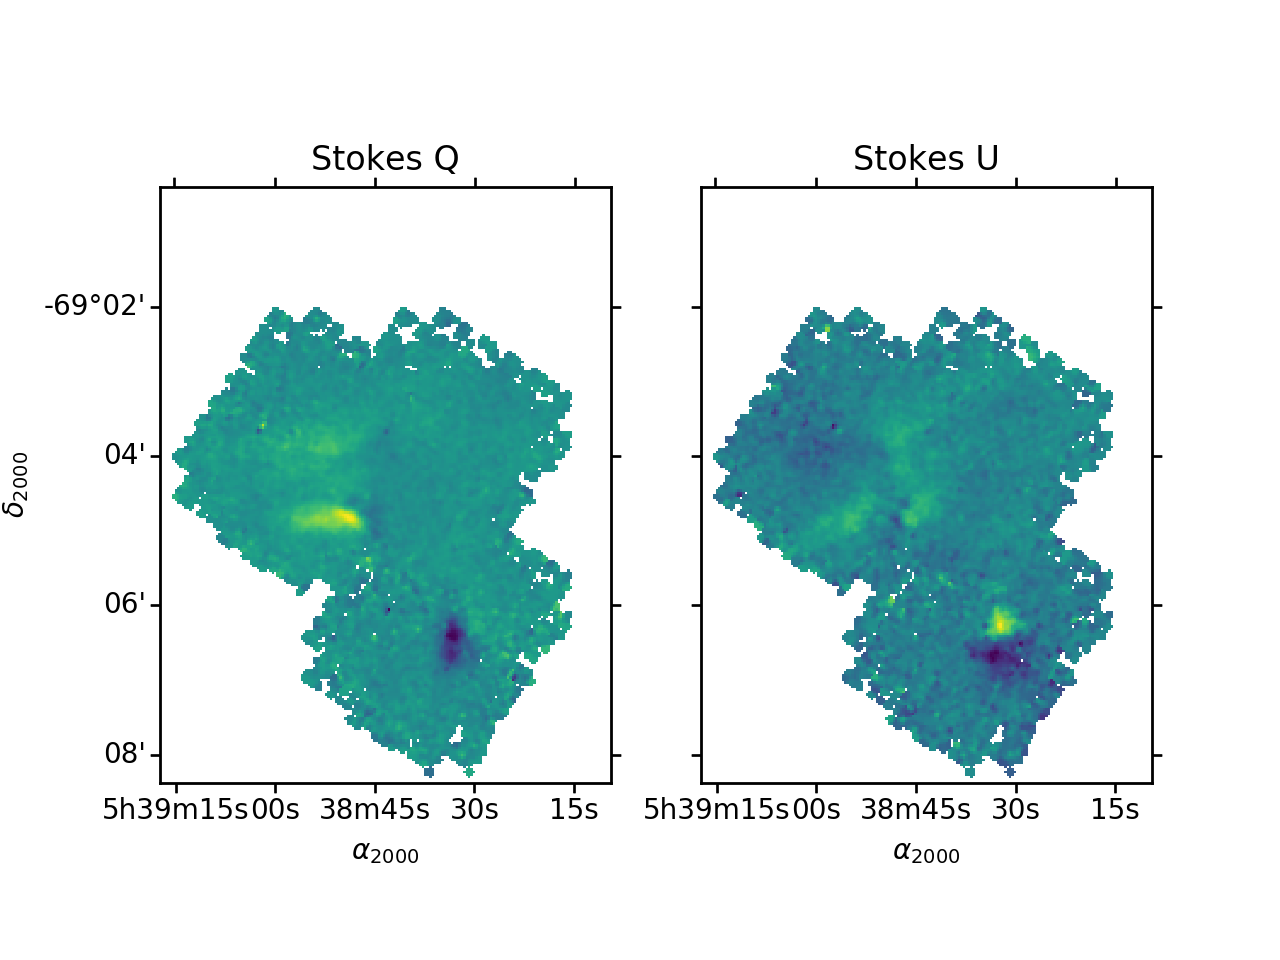

In [4]:
stokes_q = hawc['STOKES Q']
stokes_q.wcs = WCS(stokes_q.header)

stokes_u = hawc['STOKES U']
stokes_u.wcs = WCS(stokes_u.header)

plt.figure()
axq = plt.subplot(1,2,1, projection=stokes_q.wcs)
axu = plt.subplot(1,2,2, projection=stokes_u.wcs)
axq.imshow(stokes_q.data,origin='lower')
axu.imshow(stokes_u.data,origin='lower')

# FORMATTING
axq.set_title('Stokes Q')
axu.set_title('Stokes U')
axq.set_xlabel(r'$\alpha_{2000}$')
axq.set_ylabel(r'$\delta_{2000}$')
axu.set_xlabel(r'$\alpha_{2000}$')
axq.coords[0].set_major_formatter('hh:mm:ss')
axu.coords[0].set_major_formatter('hh:mm:ss')
axu.coords[1].set_ticklabel_visible(False)

## Polarized Intensity $I_p$
Level 4 HAWC+ additionally provides extensions with the polarization percentage ($p$), angle ($theta$), and their associated errors ($sigma$).

Percent polarization ($p$) and error ($sigma_p$) are calculated as:

$p = 100\sqrt{\left(\frac{Q}{I}\right)^2+\left(\frac{U}{I}\right)^2}$

$\sigma_p = \frac{100}{I}\sqrt{\frac{1}{(Q^2+U^2)}\left[(Q\,\sigma_Q)^2+(U\,\sigma_U)^2+2QU\,\sigma_{QU}\right]+\left[\left(\frac{Q}{I}\right)^2+\left(\frac{U}{I}\right)^2\right]\sigma_I^2-2\frac{Q}{I}\sigma_{QI}-2\frac{U}{I}\sigma_{UI}}$ .

Note that $p$ here represents the **percent** polarization as opposed to the more typical convention for $p$ as the **fractional** polarization.

Maps of these data are found in extensions 7 (PERCENT POL) and 9 (ERROR PERCENT POL).

Polarized intensity, $I_p$, can then be calculated as $I_p = \frac{I\times p}{100}$, which is included in extension 13 (POL FLUX).

Also included is the debiased polarization percentage ($p^\prime$) calculated as:

$p^\prime=\sqrt{p^2-\sigma_p^2}$, found in extension 8 (DEBIASED PERCENT POL).

We similarly define the debiased polarized intensity as $I_{p^\prime} = \frac{I\times p^\prime}{100}$, which is included in extension 15 (DEBIASED POL FLUX).

<IPython.core.display.Javascript object>


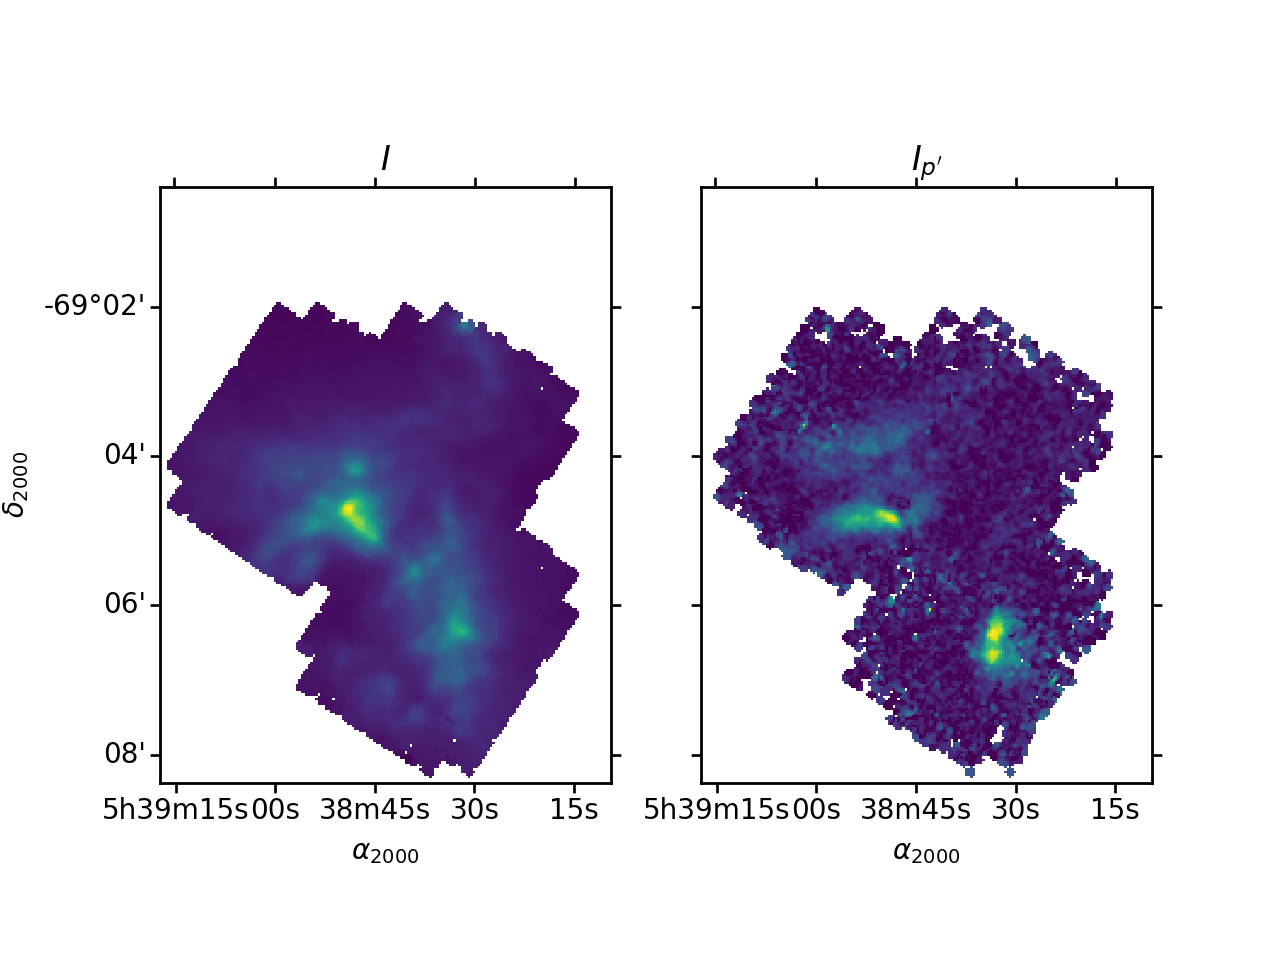

In [5]:
stokes_ip = hawc['DEBIASED POL FLUX']

fig = plt.figure()
axi = plt.subplot(1,2,1, projection=stokes_i.wcs)
axp = plt.subplot(1,2,2, projection=stokes_i.wcs)

axi.imshow( stokes_i.data, origin='lower')
axp.imshow(stokes_ip.data, origin='lower')

# FORMATTING
axi.set_title(r'$I$')
axp.set_title(r'$I_{p^\prime}$')
axi.set_xlabel(r'$\alpha_{2000}$')
axp.set_xlabel(r'$\alpha_{2000}$')
axi.set_ylabel(r'$\delta_{2000}$')
axi.coords[0].set_major_formatter('hh:mm:ss')
axp.coords[0].set_major_formatter('hh:mm:ss')
axp.coords[1].set_ticklabel_visible(False)

<IPython.core.display.Javascript object>


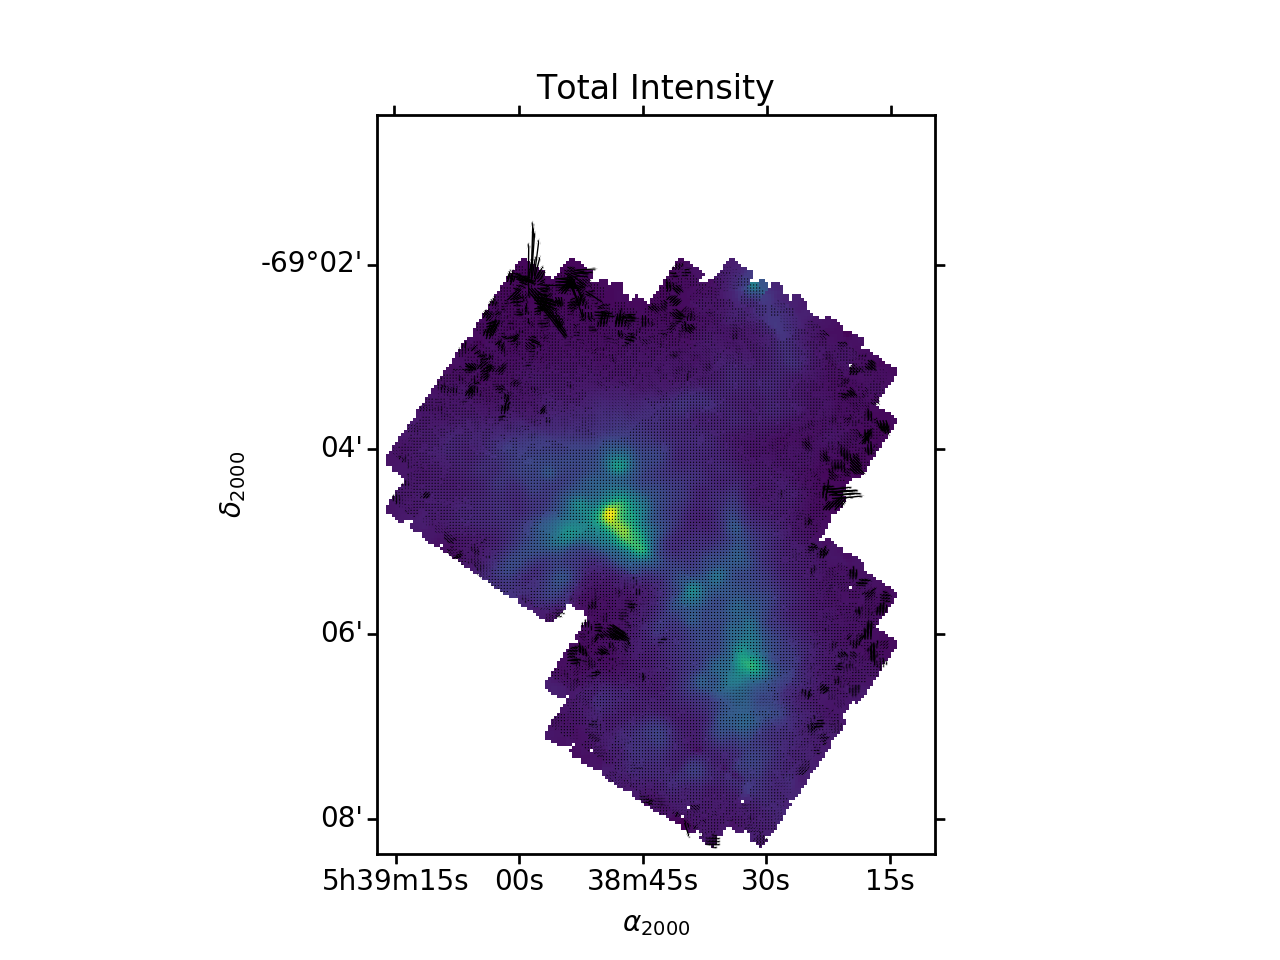

In [6]:
p = hawc['DEBIASED PERCENT POL']   # %
theta = hawc['ROTATED POL ANGLE']  # deg

plt.figure()
ax = plt.subplot(projection=stokes_i.wcs)
ax.imshow(stokes_i.data,origin='lower')

# Compute U,V  (x,y components of polarization arrow vectors)
U = p.data * np.cos(theta.data*np.pi/180)  # argument to numpy trig functions must be in radians
V = p.data * np.sin(theta.data*np.pi/180)

ax.quiver(U,V,headaxislength=0)

# FORMATTING
ax.set_title('Total Intensity')
ax.set_xlabel(r'$\alpha_{2000}$')
ax.set_ylabel(r'$\delta_{2000}$')
ax.coords[0].set_major_formatter('hh:mm:ss')
#ax.set_xlim([10,80])  # we zoom in a bit since the NaNs at the edges
#ax.set_ylim([10,80])  #  make the residuals blow up

One can certainly play around with some of the configuration options to `quiver`, such as scaling and masking out bad pixels. However, another option is binnng.  To visualize some of the larger scale vector flows, we can bin both the magnitude and angle of the polarization vectors.  We do this below by downsampling and summing the magnitudes ($p$) and averaging the angles of the vectors ($\theta$) in each bin.

<IPython.core.display.Javascript object>


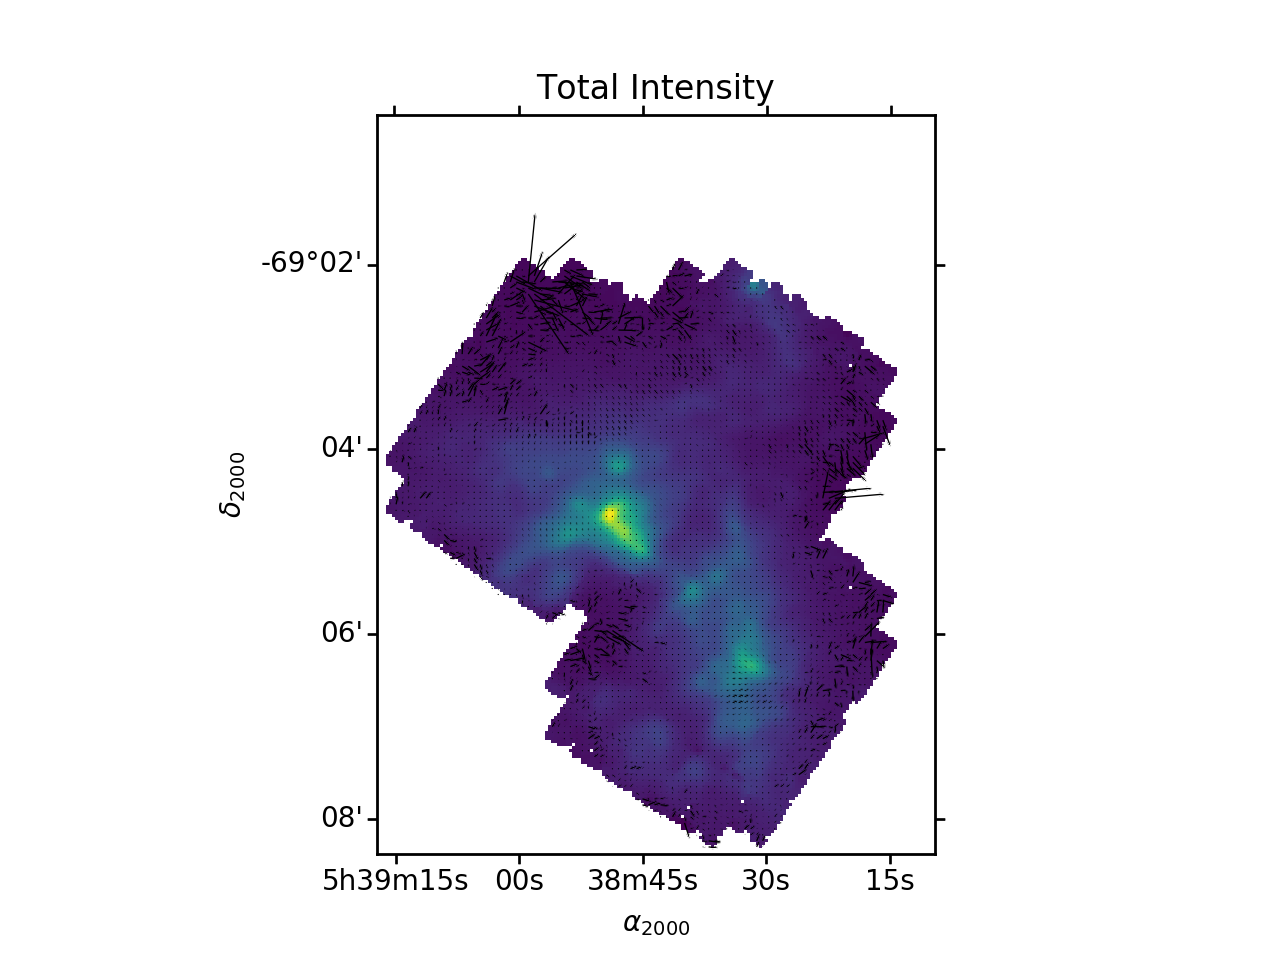

interactive(children=(IntSlider(value=2, description='block size', max=8, min=1), Output()), _dom_classes=('wi…

In [7]:
from astropy.nddata.utils import block_reduce

fig = plt.figure()
ax = plt.subplot(projection=stokes_i.wcs)
im = ax.imshow(stokes_i.data,origin='lower')

plotted = [im]

def rebin(n=2):
    # combine nxn pixels
    mag   = block_reduce(p.data,     block_size=n, func=np.nansum)
    angle = block_reduce(theta.data, block_size=n, func=np.nanmean)

    # Compute U,V  (x,y components of polarization arrow vectors)
    U = mag * np.cos(angle*np.pi/180)  # argument to numpy trig functions must be in radians
    V = mag * np.sin(angle*np.pi/180)

    # We cannot simply plot U and V anymore because these arrays are now much smaller
    #   than the background image
    # We can either downsample the Stokes I image as well, or we can alter the spacing of the 
    #   U and V vector coordinates

    Y,X = np.mgrid[0:mag.shape[0]*n:n,
                   0:mag.shape[1]*n:n]   ##!! [this is potentially misaligned?]

    ## this is just for the interactive widget
    if len(plotted) == 2:
        plotted.pop().remove()
        
    lines = ax.quiver(X,Y,U,V,headaxislength=0)
    plotted.append(lines)  # store for removing if widget is updated
    
widget = interact(rebin,
             n=IntSlider(min=1,max=8,step=1,value=2,description='block size'))

# FORMATTING
ax.set_title('Total Intensity')
ax.set_xlabel(r'$\alpha_{2000}$')
ax.set_ylabel(r'$\delta_{2000}$')
ax.coords[0].set_major_formatter('hh:mm:ss')